In [1]:
!pip3 install tensorflow

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [3]:
class Predictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super(Predictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [4]:
def prepare_country_data(country_data, sequence_length=5):
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(country_data.reshape(-1, 1))
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length])
    
    return np.array(X), np.array(y), scaler


In [5]:
def train_model(X, y, epochs=200):
    # Create dataset and dataloader
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    # Initialize model
    model = Predictor(input_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')
    
    return model

In [6]:
def predict_future(model, last_sequence, scaler, n_future=5):
    model.eval()
    current_sequence = last_sequence.copy()
    predictions = []
    
    with torch.no_grad():
        for _ in range(n_future):
            sequence = torch.FloatTensor(current_sequence).unsqueeze(0)
            pred = model(sequence)
            predictions.append(pred.numpy())
            current_sequence = np.vstack((current_sequence[1:], pred.numpy()))
    
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()


In [8]:
df = pd.read_csv('../datasets/co2#2.csv')
df.head()
df.replace("..", pd.NA, inplace=True)
# Forward fill first, then backward fill to handle any remaining NAs at the start
df.rename(columns={'country': 'Country'}, inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.ffill().bfill()
df.head()

,Country,1990 CO2 per capita,1991 CO2 per capita,1992 CO2 per capita,1993 CO2 per capita,1994 CO2 per capita,1995 CO2 per capita,1996 CO2 per capita,1997 CO2 per capita,1998 CO2 per capita,...,2014 CO2 per capita,2015 CO2 per capita,2016 CO2 per capita,2017 CO2 per capita,2018 CO2 per capita,2019 CO2 per capita,2020 CO2 per capita,2021 CO2 per capita,2022 CO2 per capita,2023 CO2 per capita
0,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.0
1,Africa,0.906,0.919,0.915,0.924,1.003,1.028,1.002,1.004,1.039,...,1.123,1.101,1.09,1.039,1.012,1.043,0.956,0.990,0.946,0.0
2,Africa (GCP),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.0
3,Albania,1.695,1.406,0.888,0.815,0.726,0.781,0.932,0.690,0.790,...,2.242,2.040,2.01,2.055,2.053,2.022,2.009,2.147,2.127,0.0
4,Algeria,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.0


In [10]:
cols = [col for col in df.columns if 'CO2' in col]
    
sequence_length = 5
predictions_by_country = {}
selected_countries = ['United States', 'China', 'Japan', 'Germany', 'United Kingdom']

In [11]:
for country in df['Country']:
        print(f"\nTraining model for {country}")
        
        # Get country data
        country_data = df[df['Country'] == country][cols].values.flatten()

        country_data = country_data.astype(float)
        
        # Prepare data
        X, y, scaler = prepare_country_data(country_data, sequence_length)
        
        if len(X) > 0:  # Check if we have enough data
            # Train model
            model = train_model(X, y)
            
            # Make predictions
            last_sequence = scaler.transform(country_data[-sequence_length:].reshape(-1, 1))
            predictions = predict_future(model, last_sequence, scaler)
            predictions_by_country[country] = predictions
    


Training model for Afghanistan
Epoch [50/200], Loss: 0.0000
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000

Training model for Africa
Epoch [50/200], Loss: 0.0276
Epoch [100/200], Loss: 0.0269
Epoch [150/200], Loss: 0.0275
Epoch [200/200], Loss: 0.0276

Training model for Africa (GCP)
Epoch [50/200], Loss: 0.0000
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000

Training model for Albania
Epoch [50/200], Loss: 0.0343
Epoch [100/200], Loss: 0.0333
Epoch [150/200], Loss: 0.0316
Epoch [200/200], Loss: 0.0316

Training model for Algeria
Epoch [50/200], Loss: 0.0000
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000

Training model for Andorra
Epoch [50/200], Loss: 0.0000
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000

Training model for Angola
Epoch [50/200], Loss: 0.0000
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0

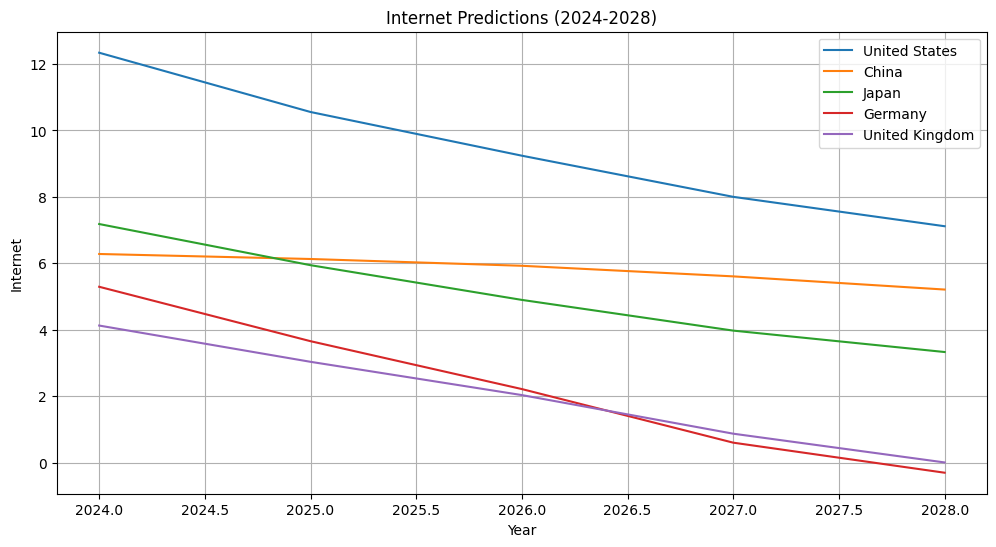


Predicted Internet (2024-2028):

United States:
2024: $12.34
2025: $10.56
2026: $9.24
2027: $8.00
2028: $7.12

China:
2024: $6.28
2025: $6.13
2026: $5.93
2027: $5.61
2028: $5.21

Japan:
2024: $7.18
2025: $5.95
2026: $4.90
2027: $3.98
2028: $3.33

Germany:
2024: $5.30
2025: $3.66
2026: $2.22
2027: $0.60
2028: $-0.30

United Kingdom:
2024: $4.13
2025: $3.04
2026: $2.04
2027: $0.87
2028: $0.01


In [12]:
plt.figure(figsize=(12, 6))
for country in selected_countries:
    if country in predictions_by_country:
        plt.plot(range(2024, 2029), predictions_by_country[country], label=country)
plt.title('Internet Predictions (2024-2028)')
plt.xlabel('Year')
plt.ylabel('Internet')
plt.legend()
plt.grid(True)
plt.show()
    
    # Print predictions for selected countries
print("\nPredicted Internet (2024-2028):")
for country in selected_countries:
    if country in predictions_by_country:
        print(f"\n{country}:")
        for year, pred in zip(range(2024, 2029), predictions_by_country[country]):
            print(f"{year}: ${pred:,.2f}")

In [13]:
# Export predictions to CSV
predictions_df = pd.DataFrame()
predictions_df['Country'] = list(predictions_by_country.keys())

for year in range(2024, 2029):
    year_predictions = []
    for country in predictions_df['Country']:
        if country in predictions_by_country:
            year_predictions.append(predictions_by_country[country][year-2024])
        else:
            year_predictions.append(None)
    predictions_df[f'{year} CO2#2'] = year_predictions

predictions_df.to_csv('../lstm_datasets/CO2#2_prediction.csv', index=False)
print("\nPredictions exported to lstm_datasets/CO2#2_prediction.csv")



Predictions exported to lstm_datasets/CO2#2_prediction.csv
